# 1. Importing Libraries and Data

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [5]:
ds = tfds.load('fashion_mnist', split='train')

2024-03-21 19:45:55.122679: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

2024-03-21 19:46:11.801715: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-21 19:46:11.801737: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-21 19:46:11.801741: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-21 19:46:11.801772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 19:46:11.801786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Shuffling /Users/sabari/tensorflow_datasets/fashion_mnist/3.0.1.incomplete59KQR9/fashion_mnist-train.tfrecord*…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /Users/sabari/tensorflow_datasets/fashion_mnist/3.0.1.incomplete59KQR9/fashion_mnist-test.tfrecord*.…

Dataset fashion_mnist downloaded and prepared to /Users/sabari/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
type(ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [7]:
ds.as_numpy_iterator().next().keys()

2024-03-21 19:53:24.939327: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


dict_keys(['image', 'label'])

# 2. Visualizing Data and Building Dataset

In [8]:
dataiterator = ds.as_numpy_iterator()

In [12]:
dataiterator.next()['image'].shape

(28, 28, 1)

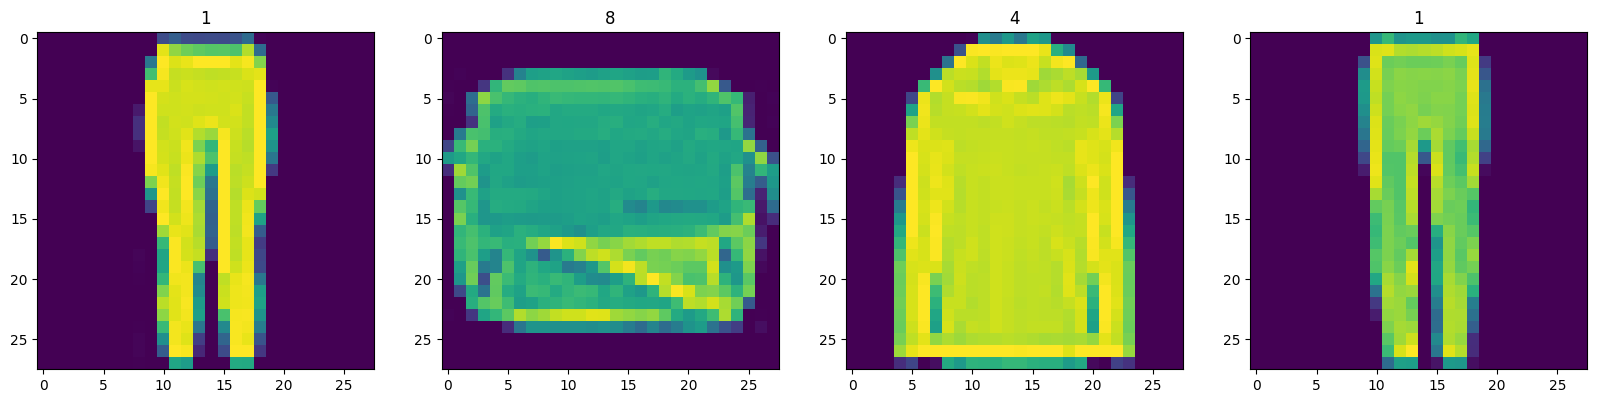

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [16]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [17]:
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()

ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)

ds = ds.prefetch(64)

In [19]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Building Neural Network

**3.1 Importing model components**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

**3.2 Building Generator**

In [23]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [24]:
generator = build_generator()

In [25]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [26]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

2024-03-21 21:23:29.364271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 904ms/step


(4, 28, 28, 1)

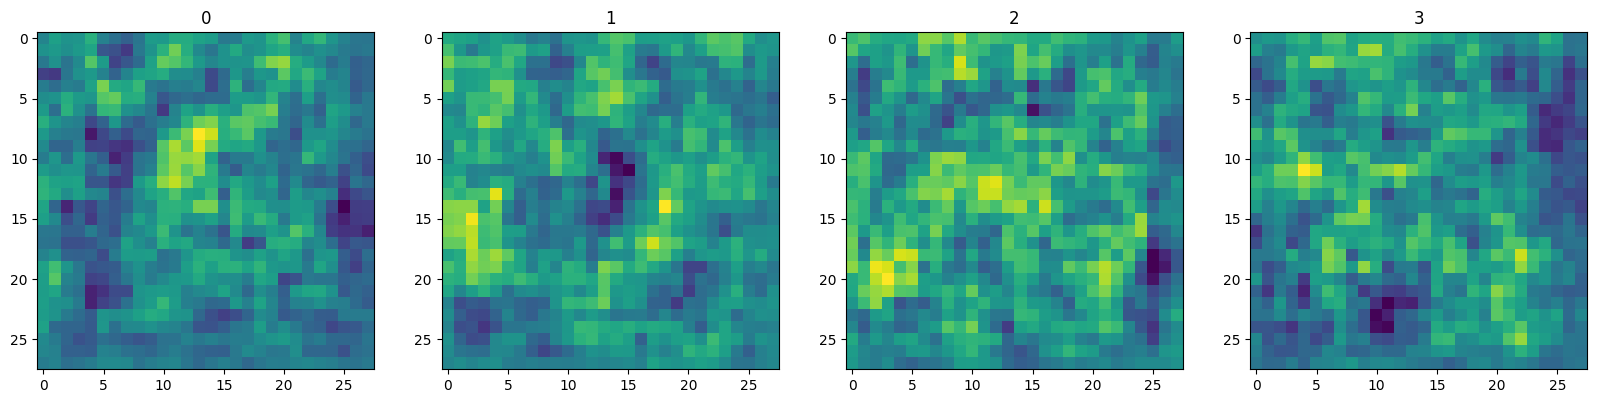

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

**3.3 Building Discriminator**

In [28]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [29]:
discriminator = build_discriminator()

In [30]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [31]:
img.shape

(28, 28, 1)

In [32]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 237ms/step


array([[0.5015696]], dtype=float32)

# 4. Constructing Training loop

**4.1 Setting up Losses and Optimizers**

In [37]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers.legacy import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [38]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

**4.2 Building Subclass model**

In [39]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [40]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Passing through any args and kawrgs to the base class
        super().__init__(*args, **kwargs)
        
        # Create attributes for generator and discriminator
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self, batch):   # For fitting the model and if we want to evaluate we create test_step
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation to neural network to learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss": total_d_loss, "g_loss": total_g_loss}


In [41]:
# Creating instance of the subclassed model
fashion_gan = GAN(generator, discriminator)

In [42]:
fashion_gan.compile(g_opt, d_opt, g_loss, d_loss)

**4.3 Building callback**

In [43]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [44]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

**4.4 Training**

In [46]:
# 2000 epochs are recommended for better model
hist = fashion_gan.fit(ds, epochs=25, callbacks=[ModelMonitor()])

Epoch 1/25


469/469 [==============================] - 202s 431ms/step - d_loss: 0.5740 - g_loss: 0.9880
Epoch 2/25
469/469 [==============================] - 157s 335ms/step - d_loss: 0.3856 - g_loss: 0.3211
Epoch 3/25
469/469 [==============================] - 146s 311ms/step - d_loss: 0.3262 - g_loss: 0.1490
Epoch 4/25
469/469 [==============================] - 148s 316ms/step - d_loss: 0.5577 - g_loss: 0.2975
Epoch 5/25
469/469 [==============================] - 152s 323ms/step - d_loss: 0.3726 - g_loss: 0.2604
Epoch 6/25
469/469 [==============================] - 152s 324ms/step - d_loss: 0.4276 - g_loss: 0.1850
Epoch 7/25
469/469 [==============================] - 147s 313ms/step - d_loss: 0.6368 - g_loss: 0.5175
Epoch 8/25
469/469 [==============================] - 146s 312ms/step - d_loss: 0.6714 - g_loss: 0.6005
Epoch 9/25
469/469 [==============================] - 139s 297ms/step - d_loss: 0.6841 - g_loss: 0.6204
Epoch 10/25
469/469 [==============================] - 134s 285ms/step - d_

**4.5 Review Performance**

In [48]:
hist.history.keys()

dict_keys(['d_loss', 'g_loss'])

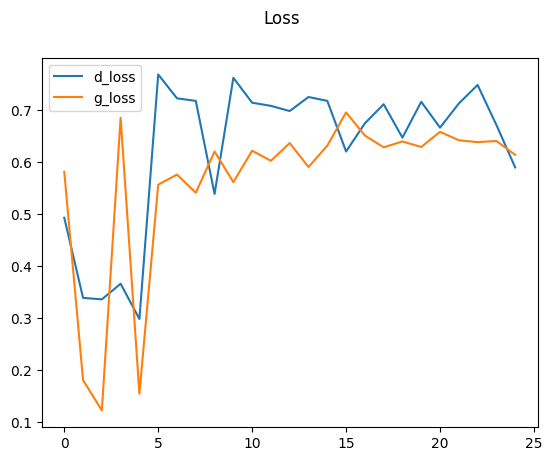

In [49]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()

# 5. Testing the Generator

**5.1 Generating images**

In [50]:
imgs = generator.predict(tf.random.normal((16,128,1)))

1/1 [==============================] - 0s 67ms/step


In [51]:
imgs.shape

(16, 28, 28, 1)

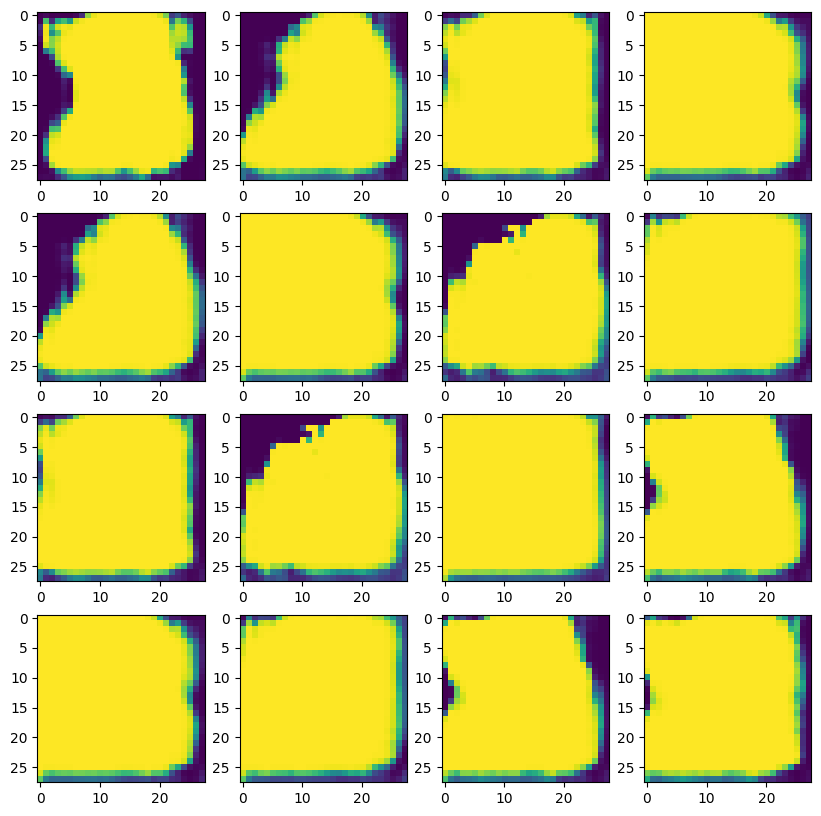

In [52]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

**5.2 Saving the model**

In [53]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/Users/sabari/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**5.3 Loading the pretrained model that has run over 2000 epochs and generating new samples**

In [ ]:
# Loading fully trained model
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16,128,1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])